In [ ]:
import pytensor.tensor as pt
import pymc as pm
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sns.set_theme()

from nltk.grammar import PCFG
from lossy_tensor import ProgressiveNoiseModel
import grammars

In [2]:
pcfg_russian = PCFG.fromstring(
    grammars.gen_russian_grammar_exp2(
        p_src = 0.58,
        p_src_local = 0.99,
        p_src_case_marked = 0.9,
        p_orc_local = 0.36,
        p_orc_case_marked = 0.83,
        p_one_arg = 0.97,
        p_adj_interveners = 0.16,
        p_one_adj = 0.95
    )
)

true_intercept = np.float64(200)
true_F = np.float64(10)
true_sigma = np.float64(0.1)

true_delta = np.float64(0.7)
true_nu = np.float64(0.5)
model = ProgressiveNoiseModel(pcfg_russian, true_delta, true_nu)

true_vals = [true_intercept, true_F, true_sigma, true_delta, true_nu]

sequences = ["RPNom V DO", "RPNom DO V", "RPAcc V Subj", "RPAcc Subj V"]
sequences = [sequence.split() for sequence in sequences]

In [3]:
n = 100

with pm.Model() as generative_model:
    print("Initialising generative model...")
    tic = time.perf_counter()

    D = pm.Deterministic("D", model.processing_difficulty(sequences, true_delta, true_nu))
    true_Sigma = true_sigma ** 2 * np.eye(len(sequences))

    rt = pm.MvNormal("rt", true_intercept + true_F * D, true_Sigma)

    print(f"Finished generative model initialisation in {time.perf_counter() - tic} seconds.")

    print(f"Generating {n} data points...")
    tic = time.perf_counter()
    data = pm.draw(rt, n, random_seed = 12)
    t = time.perf_counter() - tic
    print("Finished drawing data.")

Initialising generative model...
Finished generative model initialisation in 0.06068333399889525 seconds.
Generating 100 data points...
Finished drawing data.


In [4]:
with pm.Model() as deterministic_model:
    print("Initialising predictive model...")
    tic = time.perf_counter()

    alpha = pm.Normal("alpha", 225, 30)
    F = pm.Normal("F", 4, 1)
    sigma = pm.TruncatedNormal("sigma", mu = 0, sigma = 1, lower = 0)
    Sigma = sigma ** 2 * pt.eye(len(sequences))

    delta = pm.Beta("delta", 1, 1)
    nu = pm.Beta("nu", 1, 1)

    D = pm.Deterministic("D", model.processing_difficulty(sequences, delta, nu))

    rt = pm.MvNormal("rt", alpha + F * D, Sigma, observed = data)

    print(f"Finished predictive model initialisation in {time.perf_counter() - tic} seconds.")

    print("Fitting model...")
    tic = time.perf_counter()
    idata = pm.sample(mp_ctx = "forkserver")
    t = time.perf_counter() - tic
    print(f"Fitted model in {t} seconds.")

Initialising predictive model...
Finished predictive model initialisation in 3.0134418750094483 seconds.
Fitting model...


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, F, sigma, delta, nu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Fitted model in 224.15643308400468 seconds.


In [5]:
sampled_variables = {}

for variable in ["alpha", "F", "sigma", "delta", "nu"]:
    sampled_variables[variable] = idata.posterior[variable].values.flatten()

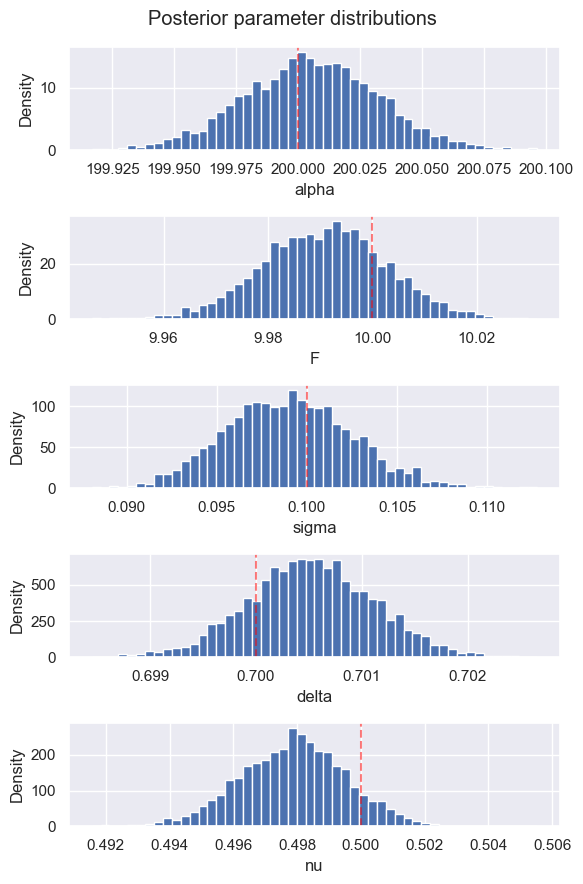

In [6]:
fig, axes = plt.subplots(len(sampled_variables), 1, layout = "tight")

for (axis, (variable, samples), true_val) in zip(axes, sampled_variables.items(), true_vals):
    axis.hist(samples, bins = 50, density = True)
    axis.axvline(true_val, color = "red", alpha = 0.5, linestyle = "dashed")
    axis.set_xlabel(variable)
    axis.set_ylabel("Density")

fig.suptitle("Posterior parameter distributions")

fig.set_size_inches(6, 9)

plt.show();

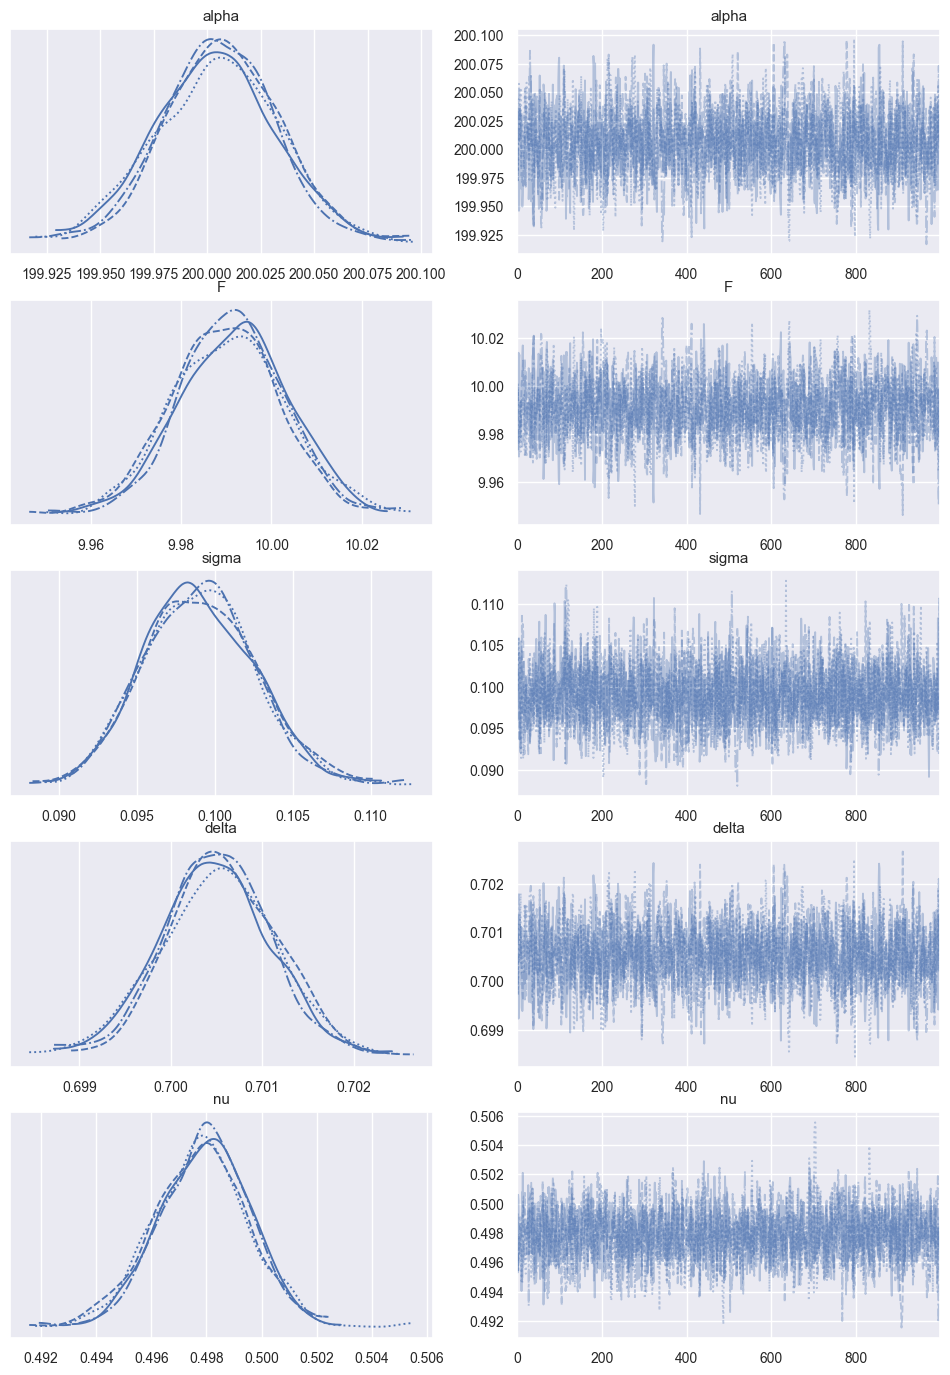

In [12]:
az.plot_trace(idata, figsize=(12, 17), var_names=["alpha", "F", "sigma", "delta", "nu"]);